In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import yt

In [2]:
import h5py
from pyfftw.interfaces.numpy_fft import fftn

In [3]:
from math import ceil

In [4]:
from scipy.stats import binned_statistic
from scipy import signal
from matplotlib.colors import LogNorm, Normalize

In [5]:
NUMTHREADS = 8 # number of threads to be used in the fftws

In [6]:
def Freq(RES):
    """compute fourier frequencies of scalar field on cube of size 1"""

    freq= np.fft.fftfreq(RES, 1./RES)

    #k-x 
    ifreq = np.fromfunction(lambda i,j,k : freq[i], (RES,RES,RES), dtype=int)
    #k-y 
    jfreq = np.fromfunction(lambda i,j,k : freq[j], (RES,RES,RES), dtype=int)
    #k-z 
    kfreq = np.fromfunction(lambda i,j,k : freq[k], (RES,RES,RES), dtype=int)

    #total k-number - largest k = sqrt(3)*RES/2- along the diagonal of the cube
    totfreq = np.sqrt(ifreq*ifreq+jfreq*jfreq+kfreq*kfreq)

    return totfreq


In [7]:
def getFTEn(Qx,Qy,Qz,RES,rho=None,pow_rho=1.):        
    
    if rho is None:
        rho = 1.
        pow_rho = 0.

    inData = rho**pow_rho*Qx
    FTQx = fftn(inData,threads=NUMTHREADS)

    inData = rho**pow_rho*Qy
    FTQy = fftn(inData,threads=NUMTHREADS)
    
    inData =  rho**pow_rho*Qz
    FTQz = fftn(inData,threads=NUMTHREADS)
    

    FTEn = np.real(0.5 * (np.abs(FTQx)**2. + np.abs(FTQy)**2. + np.abs(FTQz)**2.)/RES**3.)
    return FTEn


In [8]:
def normedVolSpec(k,quantity,RES):
    kMaxInt = ceil(RES*0.5*np.sqrt(3.))
    Bins = np.linspace(0.,kMaxInt,kMaxInt+1)
    histSum = binned_statistic(k,quantity,bins=Bins,statistic='sum')[0]
    kSum = binned_statistic(k,k,bins=Bins,statistic='sum')[0]
    histCount = np.histogram(k,bins=Bins)[0]


    # get rid of bins with 0 cells -> no division by 0 in normalization
    mask = histCount != 0

    # calculate corresponding k to to bin
    # this is more accurate (wrt energy conservation) than using the bin center
    centeredK = kSum[mask] / histCount[mask]

    #  "integrate" over k-shells
    vals = 4./3. * np.pi * (Bins[1:]**3. - Bins[:-1]**3.) * (histSum[mask] / histCount[mask])

    # normalize by cell count/resolution to get a proper energy density
    vals /= float(RES**3.)
    
    # 
    centeredK[0] = 1.
    return [Bins,vals,centeredK,histSum]

In [9]:
def _nd_window(data, filter_function):
    """
    Performs an in-place windowing on N-dimensional spatial-domain data.
    This is done to mitigate boundary effects in the FFT.
    https://stackoverflow.com/questions/27345861/extending-1d-function-across-3-dimensions-for-data-windowing

    Parameters
    ----------
    data : ndarray
           Input data to be windowed, modified in place.
    filter_function : 1D window generation function
           Function should accept one argument: the window length.
           Example: scipy.signal.hamming
    """
    for axis, axis_size in enumerate(data.shape):
        # set up shape for numpy broadcasting
        filter_shape = [1, ] * data.ndim
        filter_shape[axis] = axis_size
        window = filter_function(axis_size).reshape(filter_shape)
        # scale the window intensities to maintain image intensity
        window = np.power(window, (1.0/data.ndim))
        data *= window

In [10]:
ds = yt.load('/mnt/research/SNAPhU/m25_3d/m25_mri_o110b9_hdf5_plt_cnt_0566')

yt : [INFO     ] 2019-06-06 11:35:04,281 Parameters: current_time              = 0.5660022471091585
yt : [INFO     ] 2019-06-06 11:35:04,282 Parameters: domain_dimensions         = [80 80 80]
yt : [INFO     ] 2019-06-06 11:35:04,282 Parameters: domain_left_edge          = [-1.e+09 -1.e+09 -1.e+09]
yt : [INFO     ] 2019-06-06 11:35:04,283 Parameters: domain_right_edge         = [1.e+09 1.e+09 1.e+09]
yt : [INFO     ] 2019-06-06 11:35:04,283 Parameters: cosmological_simulation   = 0.0


In [11]:
ds.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	   125	        512000	            80
  1	   216	        884736	            96
  2	   512	       2097152	           128
  3	   512	       2097152	           128
  4	  1368	       5603328	           178
  5	  2104	       8617984	           206
  6	  3672	      15040512	           247
  7	 11424	      46792704	           361
  8	 12544	      51380224	           372
  9	 12544	      51380224	           372
----------------------------------------------
   	 45021	     184406016


t = 5.66002247e-01 = 5.66002247e-01 s = 1.79355289e-08 years

Smallest Cell:
	Width: 1.582e-20 Mpc
	Width: 1.582e-14 pc
	Width: 3.264e-09 AU
	Width: 4.883e+04 cm


In [12]:
ad = ds.all_data()

# analyze central data at the highest resolution

In [13]:
# exact the maximum region on the finest level
max_level = int(ad[('index','grid_level')].max())
filter_str = "obj['grid_level'] == %d" % max_level
ad_max_level = ad.cut_region(filter_str)

min_dx = ad[('index','dx')].min().in_units('km')

left_edge = ds.arr([
    ad_max_level[('index','x')].min(),
    ad_max_level[('index','y')].min(),
    ad_max_level[('index','z')].min()
])
right_edge = ds.arr([
    ad_max_level[('index','x')].max(),
    ad_max_level[('index','y')].max(),
    ad_max_level[('index','z')].max()
])
print('left edge:  ', left_edge.in_units('km'))
print('right_edge: ', right_edge.in_units('km'))

# effective grid size
max_dims = np.array(((right_edge - left_edge)/min_dx),dtype=int)
print('grid size: ', max_dims)

central_grid = ds.smoothed_covering_grid(max_level,left_edge,max_dims)

left edge:   [-109.13085938 -109.13085938 -109.13085938] km
right_edge:  [109.13085938 109.13085938 109.13085938] km
grid size:  [446 446 446]


In [14]:
# create vectors for analysis (and remove yt units)
rho = central_grid[('gas','density')].d
u = np.array([
    central_grid[('gas','velocity_x')].d,
    central_grid[('gas','velocity_y')].d,
    central_grid[('gas','velocity_z')].d
])
B = np.array([
    central_grid[('gas','magnetic_field_x')].d,
    central_grid[('gas','magnetic_field_y')].d,
    central_grid[('gas','magnetic_field_z')].d
])

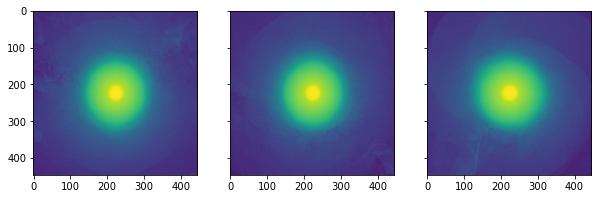

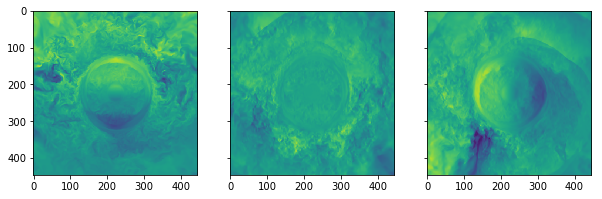

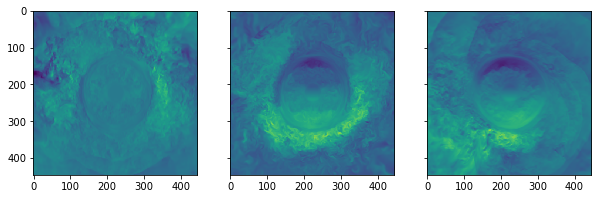

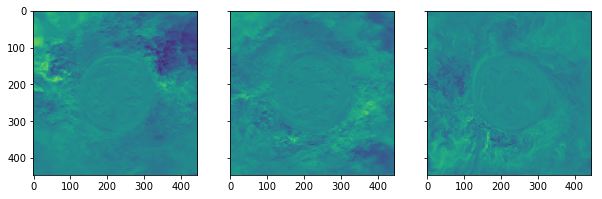

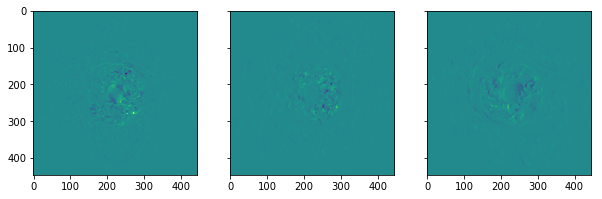

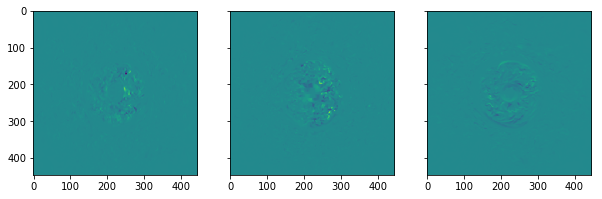

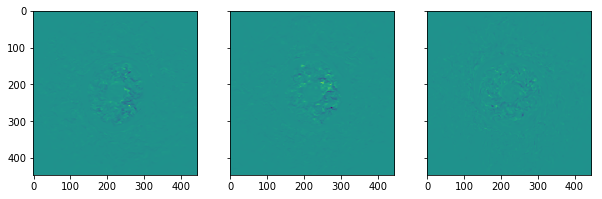

In [15]:
# sanity check 
def sliceplot_field(field):
    center_idx = field.shape[0]//2
    field_min = np.min(field)
    field_max = np.max(field)
    
    if field_min > 0 and np.log10(field_max) - np.log10(field_min) > 2:
        norm = LogNorm(vmin=field_min,vmax=field_max)
    else:
        norm = Normalize(vmin=field_min,vmax=field_max)
    
    fig, p = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,4))
    p[0].imshow(field[center_idx,:,:],norm=norm)
    p[1].imshow(field[:,center_idx,:],norm=norm)
    p[2].imshow(field[:,:,center_idx],norm=norm)

sliceplot_field(rho)
sliceplot_field(u[0])
sliceplot_field(u[1])
sliceplot_field(u[2])
sliceplot_field(B[0])
sliceplot_field(B[1])
sliceplot_field(B[2])


In [16]:
# get raw spectra without filtering
RES = max_dims[0]
k = Freq(RES)

FTEn = getFTEn(u[0], u[1], u[2],RES)
spec_cube_u2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(u[0], u[1], u[2],RES,rho=rho,pow_rho=0.5)
spec_cube_rhou2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(B[0], B[1], B[2],RES)
spec_cube_B2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

# apply a cubic Tukey window


In [17]:
rho_tukey_cube = np.copy(rho)
u_tukey_cube = np.copy(u)
B_tukey_cube = np.copy(B)

print('Careful this currently applies the tukey window with default parameters, e.g., wrt to the width')

_nd_window(rho_tukey_cube,signal.tukey)
for i in range(3):
    _nd_window(u_tukey_cube[i],signal.tukey)
    _nd_window(B_tukey_cube[i],signal.tukey)

Careful this currently applies the tukey window with default parameters, e.g., wrt to the width


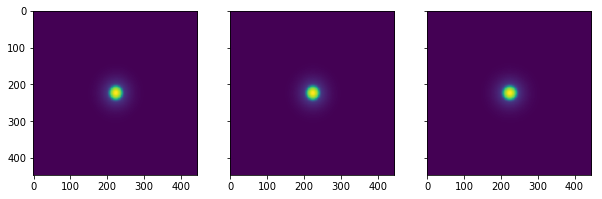

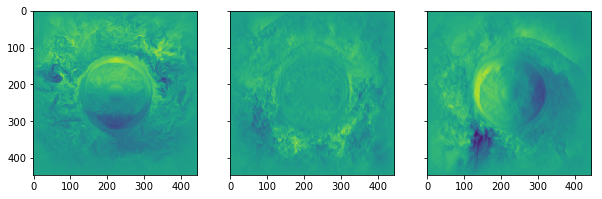

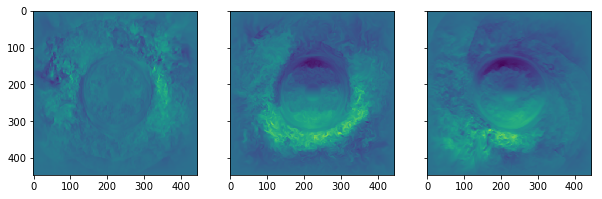

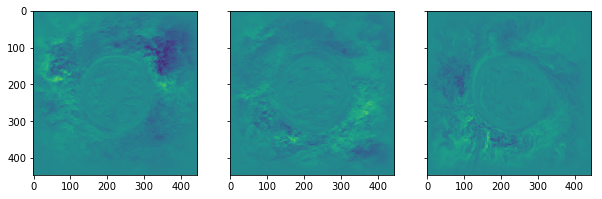

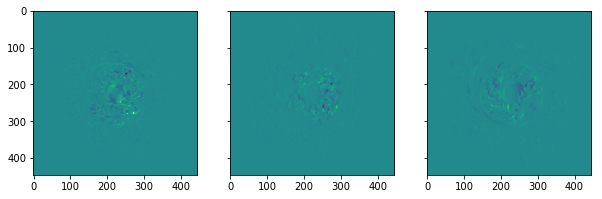

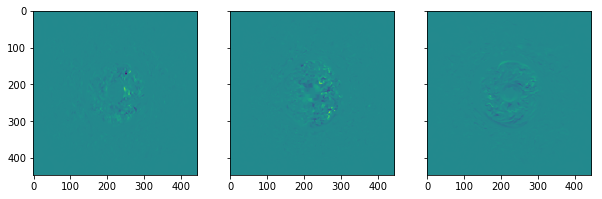

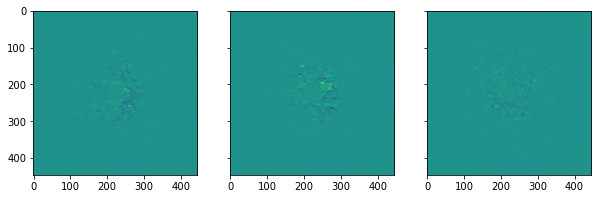

In [18]:
sliceplot_field(rho_tukey_cube)
sliceplot_field(u_tukey_cube[0])
sliceplot_field(u_tukey_cube[1])
sliceplot_field(u_tukey_cube[2])
sliceplot_field(B_tukey_cube[0])
sliceplot_field(B_tukey_cube[1])
sliceplot_field(B_tukey_cube[2])

In [19]:
# get spectra with cubic tukey window

FTEn = getFTEn(u_tukey_cube[0], u_tukey_cube[1], u_tukey_cube[2],RES)
spec_tukey_cube_u2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(u_tukey_cube[0], u_tukey_cube[1], u_tukey_cube[2],RES,rho=rho_tukey_cube,pow_rho=0.5)
spec_tukey_cube_rhou2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(B_tukey_cube[0], B_tukey_cube[1], B_tukey_cube[2],RES)
spec_tukey_cube_B2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

# Sharp sphere

In [20]:
rho_sphere = np.copy(rho)
u_sphere = np.copy(u)
B_sphere = np.copy(B)

x, y, z = np.ogrid[-RES/2+0.5:RES/2+0.5,
                   -RES/2+0.5:RES/2+0.5,
                   -RES/2+0.5:RES/2+0.5,
                  ]
radius = np.sqrt(x**2 + y**2 + z**2)

r_max = RES/2 - 1
mask = radius > r_max

rho_sphere[mask] = 0.
for i in range(3):
    u_sphere[i][mask] = 0.
    B_sphere[i][mask] = 0.

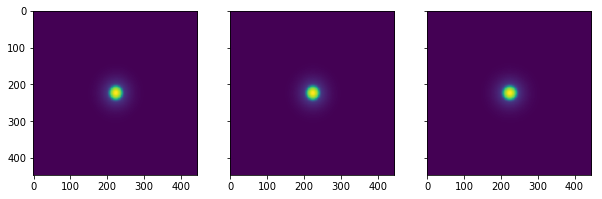

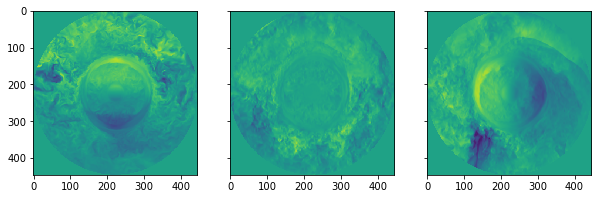

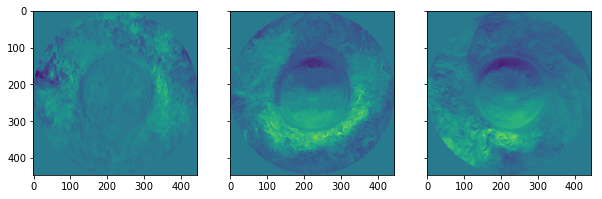

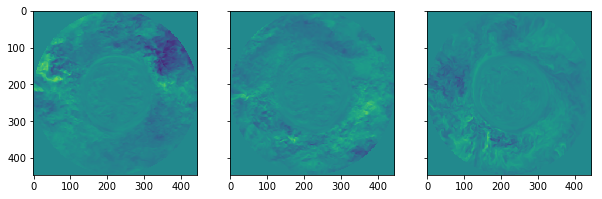

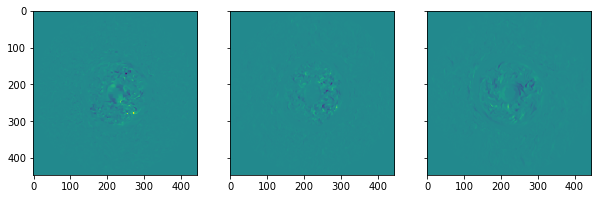

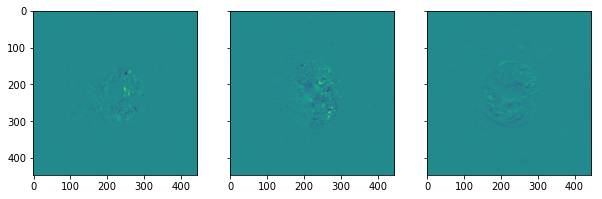

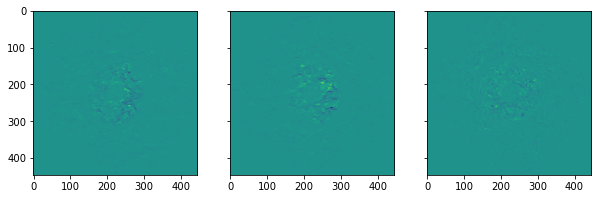

In [21]:
sliceplot_field(rho_tukey_cube)
sliceplot_field(u_sphere[0])
sliceplot_field(u_sphere[1])
sliceplot_field(u_sphere[2])
sliceplot_field(B_sphere[0])
sliceplot_field(B_sphere[1])
sliceplot_field(B_sphere[2])

In [22]:
# get spectra with cubic tukey window

FTEn = getFTEn(u_sphere[0], u_sphere[1], u_sphere[2],RES)
spec_sphere_u2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(u_sphere[0], u_sphere[1], u_sphere[2],RES,rho=rho_sphere,pow_rho=0.5)
spec_sphere_rhou2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(B_sphere[0], B_sphere[1], B_sphere[2],RES)
spec_sphere_B2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)


# Smooth sphere

In [23]:
rho_tukey_sphere = np.copy(rho)
u_tukey_sphere = np.copy(u)
B_tukey_sphere = np.copy(B)

x, y, z = np.ogrid[-RES/2+0.5:RES/2+0.5,
                   -RES/2+0.5:RES/2+0.5,
                   -RES/2+0.5:RES/2+0.5,
                  ]
radius = np.sqrt(x**2 + y**2 + z**2)

r_max = RES/2 - 1
alpha = (RES/2 - 10)/r_max

mask = radius > alpha * r_max

rho_tukey_sphere[mask] *= 0.5*(1. + np.cos(np.pi*((radius[mask] - alpha * r_max)/(r_max - alpha * r_max))))
for i in range(3):
    u_tukey_sphere[i][mask] *= 0.5*(1. + np.cos(np.pi*((radius[mask] - alpha * r_max)/(r_max - alpha * r_max))))
    B_tukey_sphere[i][mask] *= 0.5*(1. + np.cos(np.pi*((radius[mask] - alpha * r_max)/(r_max - alpha * r_max))))

mask = radius > r_max
rho_tukey_sphere[mask] = 0.
for i in range(3):
    u_tukey_sphere[i][mask] = 0.
    B_tukey_sphere[i][mask] = 0.

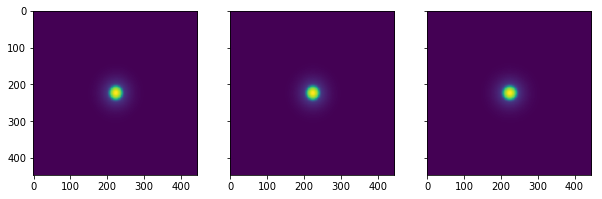

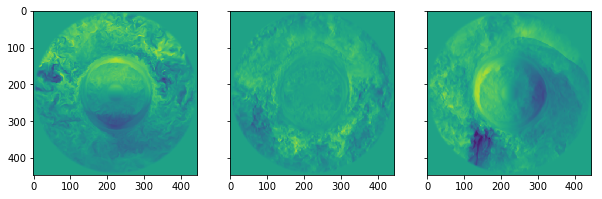

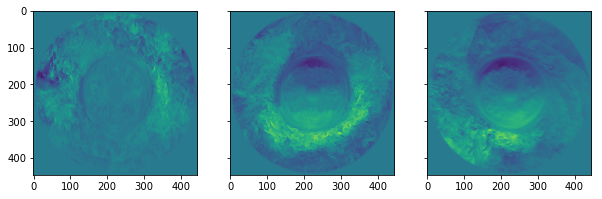

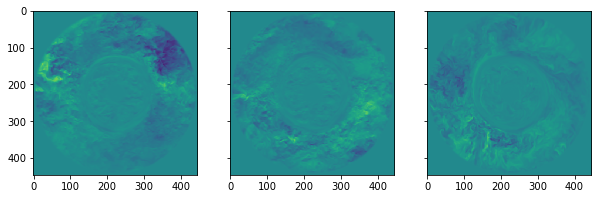

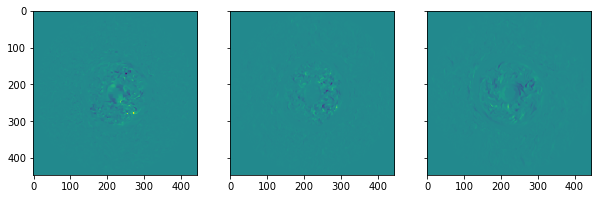

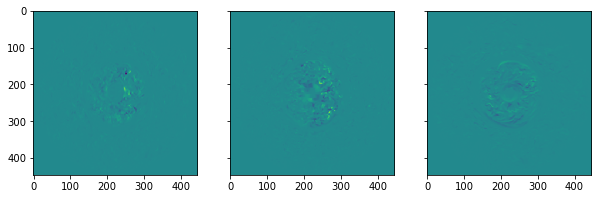

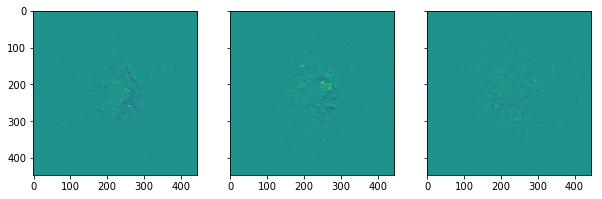

In [24]:
sliceplot_field(rho_tukey_sphere)
sliceplot_field(u_tukey_sphere[0])
sliceplot_field(u_tukey_sphere[1])
sliceplot_field(u_tukey_sphere[2])
sliceplot_field(B_tukey_sphere[0])
sliceplot_field(B_tukey_sphere[1])
sliceplot_field(B_tukey_sphere[2])

In [25]:
# get spectra with spherical tukey window

FTEn = getFTEn(u_tukey_sphere[0], u_tukey_sphere[1], u_tukey_sphere[2],RES)
spec_tukey_sphere_u2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(u_tukey_sphere[0], u_tukey_sphere[1], u_tukey_sphere[2],RES,rho=rho_tukey_sphere,pow_rho=0.5)
spec_tukey_sphere_rhou2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

FTEn = getFTEn(B_tukey_sphere[0], B_tukey_sphere[1], B_tukey_sphere[2],RES)
spec_tukey_sphere_B2 = normedVolSpec(k.reshape(-1),FTEn.reshape(-1),RES)

Text(0, 0.5, '$P(k)$')

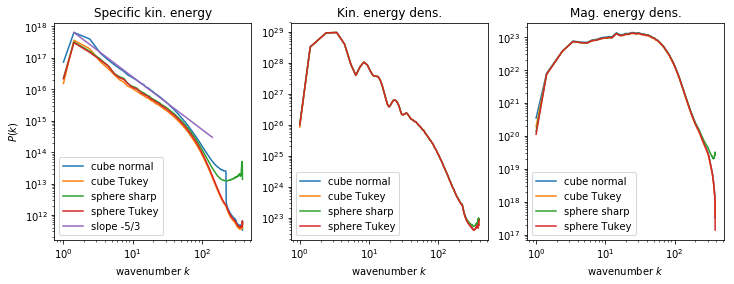

In [26]:
fig, p = plt.subplots(1,3,sharex=True,figsize=(12,4))

p[0].loglog(spec_cube_u2[2],spec_cube_u2[1],label='cube normal')
p[1].loglog(spec_cube_rhou2[2],spec_cube_rhou2[1],label='cube normal')
p[2].loglog(spec_cube_B2[2],spec_cube_B2[1],label='cube normal')

p[0].loglog(spec_tukey_cube_u2[2],spec_tukey_cube_u2[1],label='cube Tukey')
p[1].loglog(spec_tukey_cube_rhou2[2],spec_tukey_cube_rhou2[1],label='cube Tukey')
p[2].loglog(spec_tukey_cube_B2[2],spec_tukey_cube_B2[1],label='cube Tukey')

p[0].loglog(spec_sphere_u2[2],spec_sphere_u2[1],label='sphere sharp')
p[1].loglog(spec_sphere_rhou2[2],spec_sphere_rhou2[1],label='sphere sharp')
p[2].loglog(spec_sphere_B2[2],spec_sphere_B2[1],label='sphere sharp')

p[0].loglog(spec_tukey_sphere_u2[2],spec_tukey_sphere_u2[1],label='sphere Tukey')
p[1].loglog(spec_tukey_sphere_rhou2[2],spec_tukey_sphere_rhou2[1],label='sphere Tukey')
p[2].loglog(spec_tukey_sphere_B2[2],spec_tukey_sphere_B2[1],label='sphere Tukey')

kolm_x = spec_cube_u2[2][spec_cube_u2[1] == spec_cube_u2[1].max()]
kolm_y = spec_cube_u2[1].max()

p[0].loglog([kolm_x,kolm_x*100],[kolm_y,kolm_y/100**(5/3)],label='slope -5/3')

p[0].set_title('Specific kin. energy')
p[1].set_title('Kin. energy dens.')
p[2].set_title('Mag. energy dens.')


for i in range(3):
    p[i].legend()
    p[i].set_xlabel('wavenumber $k$')


p[0].set_ylabel('$P(k)$')
